In [2]:
# Imports
import sys

sys.path.insert(0, "../src")
from main import load_database

import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import yaml


import os
import subprocess
import numpy as np
import pynvml

import devaice
import audeer
import audinterface
import audmodel
import audonnx

In [3]:
# Load the labels DataFrame
# Load the experiment configuration from the YAML file
with open("../src/experiment_parameters.yaml", "r") as stream:
    config = yaml.safe_load(stream)

df_files = load_database(config)

Number of participants before filtering out too few sessions: 27; Shape of the DataFrame before filtering: (3346, 152)
Number of participants after filtering out too few sessions: 25; Shape of the DataFrame after filtering: (3304, 152)
Shape of the DataFrame after filtering prompts: (3204, 152)


In [4]:
def list_free_gpu_memory(min_memory_free=0):
    pynvml.nvmlInit()
    device_count = pynvml.nvmlDeviceGetCount()
    gpu_memory_usage = []
    # Iterate over all GPUs to get the memory usage of each
    for i in range(device_count):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        # Convert bytes to MBs
        memory_free = mem_info.free / (1024 * 1024)
        # Check if the available GPU memory is larger than the minimum required memory
        if memory_free >= min_memory_free:
            # Tuple to store the GPU id and the memory usage
            gpu_memory_usage.append((i, memory_free))
    pynvml.nvmlShutdown()

    # Sort the list gpu_memory_usage by the amount of free memory with highest available memory first
    gpu_memory_usage.sort(key=lambda x: x[1], reverse=True)

    return gpu_memory_usage


def get_gpu_with_most_memory(min_memory_free=0):
    gpu_memory_usage = list_free_gpu_memory(min_memory_free=min_memory_free)
    if gpu_memory_usage:
        # Return the GPU id of the GPU with the most available memory^
        gpu_id = gpu_memory_usage[0][0]
        # Set the environment variable CUDA_VISIBLE_DEVICES to the GPU id
        # os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
        return f"cuda:{gpu_id}"
    else:
        # If no GPU with enough memory is available, use the CPU
        return "cpu"

In [5]:
df_files.index[0]

'/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/193/03b57384-ab22-4f55-8118-6af8b6b022d5.wav'

In [6]:
session = devaice.MainDevaiceSession()
resource_root_path = "/data/phecker/devAIce-SDK-3.12.0-audEERING-Research/res/"
# The devAIce serial key is stored in an environment variable to separate if from the source
serial_key = os.getenv("DEVAICE_SERIAL_KEY")


def apply_devaice(signal, sampling_rate, session, resource_root_path, serial_key):
    def get_bit_depth(signal):
        return signal.dtype.itemsize * 8

    raw_audio_format = devaice.DevaiceRawAudioFormat(
        sample_type=devaice.DEVAICE_SAMPLE_TYPE_FLOAT,
        bit_depth=get_bit_depth(signal),
        num_channels=1,
        sample_rate=sampling_rate,
    )
    session_result = session.util_audio_quality_on_buffer(
        signal,
        raw_audio_format=raw_audio_format,
        resource_root_path=resource_root_path,
        serial_key=serial_key,
    )

    return [session_result.snr]


interface = audinterface.Feature(
    feature_names=["snr"],
    process_func=apply_devaice,
    process_func_args={
        "session": session,
        "resource_root_path": resource_root_path,
        "serial_key": serial_key,
    },
    num_workers=1,
    verbose=True,
)

snr_devaice = interface.process_index(
    index=df_files.index,
)
session.free()

In [7]:
session = devaice.MainDevaiceSession()
# config = devaice.init()  # devaice.DEVAICE_AUDIO_QUALITY_CONFIG_DEFAULT()

# devaice.file_settings_default()

session_result = session.util_audio_quality_on_file(
    path="/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/193/03b57384-ab22-4f55-8118-6af8b6b022d5.wav",
    file_settings=devaice.DevaiceFileSettings(),
    resource_root_path="/data/phecker/devAIce-SDK-3.12.0-audEERING-Research/res/",
    serial_key=os.getenv("DEVAICE_SERIAL_KEY"),
)
print("Scene result:", session_result, sep="\n", end="\n\n")
session.free()

Scene result:
snr: 7.071786880493164,
rt60: 1.2349340915679932



In [8]:
# Load the desired model
root_model = audmodel.load("b98a737c-2.4.1")
# Find GPU with most memory available
device_id = get_gpu_with_most_memory(min_memory_free=4000)
print(device_id)
# Required on compute5: fix order of CUDA devices
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
model = audonnx.load(root_model, device=device_id)


# Apply model
# audinterface.Feature, since model returns multiple dimensional output
interface = audinterface.Feature(
    model.outputs["logits"].labels,
    process_func=model,
    # Not sure, but this is requires, since otherwise get RuntimeError: Number of features must be 3, not 1.
    process_func_args={"outputs": "logits"},
    # Only 1 worker, to avoid memory issues on GPUs
    num_workers=1,
    verbose=True,
)
# idx-files also contains the sustained utterances files
logits = interface.process_index(
    index=df_files.index,
    # root=dct_idx[cur_norm]["path_audio_base"],
)

/scratch/phecker/.envs/prompt_performance-static_modelling-test-devaice/lib/python3.8/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:69: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


cuda:2


In [9]:
snr_devaice

snr
file                                              start  end                                 
/data/share/aisoundlab-mental_wellbeing_at_sea... 0 days 0 days 00:00:02.048000      7.071787
                                                         0 days 00:00:05.461312500  10.592300
                                                         0 days 00:00:05.120000      8.879777
                                                         0 days 00:00:05.461312500  10.071819
                                                         0 days 00:00:05.120000      9.860499
...                                                                                       ...
                                                         0 days 00:00:02.229125     15.800956
                                                         0 days 00:00:04.458250     12.481077
                                                         0 days 00:00:04.086687500  16.104923
                                                         0 days 00:00:03.343687500  15.064210
                                                         0 days 00:00:03.715187500  12.668301

[3204 rows x 1 columns]

In [10]:
logits["snr"]

file                                               start   end                      
/data/share/aisoundlab-mental_wellbeing_at_sea...  0 days  0 days 00:00:02.048000        7.071784
                                                           0 days 00:00:05.461312500    10.592299
                                                           0 days 00:00:05.120000        8.879775
                                                           0 days 00:00:05.461312500    10.071818
                                                           0 days 00:00:05.120000        9.860497
                                                                                          ...    
                                                           0 days 00:00:02.229125       15.800956
                                                           0 days 00:00:04.458250       12.481076
                                                           0 days 00:00:04.086687500    16.104923
                                 

In [11]:
# Check if the indices are identical
index_identical = logits["snr"].index.equals(snr_devaice.index)

# Check if the values are identical
values_identical = logits["snr"].equals(snr_devaice)

print(f"Indices are identical: {index_identical}")
print(f"Values are identical: {values_identical}")

Indices are identical: True
Values are identical: False


In [12]:
# Check the data types of the values in the two series
logits_snr_dtype = logits["snr"].dtypes
snr_devaice_dtype = snr_devaice.dtypes

print(f"Data type of logits['snr']: {logits_snr_dtype}")
print(f"Data type of snr_devaice: {snr_devaice_dtype}")

Data type of logits['snr']: float32
Data type of snr_devaice: snr    float64
dtype: object


In [13]:
# Convert snr_devaice to float32
snr_devaice = snr_devaice.astype("float32")

# Now you can compare the values again
values_identical = logits["snr"].equals(snr_devaice)

print(f"Values are identical: {values_identical}")

Values are identical: False


In [14]:
snr_devaice.dtypes

snr    float32
dtype: object

In [15]:
logits["snr"].dtypes

dtype('float32')

In [16]:
# Convert snr_devaice to a Series
snr_devaice_series = snr_devaice["snr"]

# Find the differences between the two series
differences = logits["snr"].compare(snr_devaice_series)

print(differences)

                                                                                         self  \
file                                              start  end                                    
/data/share/aisoundlab-mental_wellbeing_at_sea... 0 days 0 days 00:00:02.048000      7.071784   
                                                         0 days 00:00:05.461312500  10.592299   
                                                         0 days 00:00:05.120000      8.879775   
                                                         0 days 00:00:05.461312500  10.071818   
                                                         0 days 00:00:05.120000      9.860497   
...                                                                                       ...   
                                                         0 days 00:00:04.086687500  15.816821   
                                                         0 days 00:00:03.715187500  13.242982   
                              

In [17]:
# Calculate the absolute differences
differences["abs_diff"] = differences["self"] - differences["other"]
differences["abs_diff"] = differences["abs_diff"].abs()

# Filter the differences
large_differences = differences[differences["abs_diff"] > 0.00001]

print(large_differences)

                                                                                         self  \
file                                              start  end                                    
/data/share/aisoundlab-mental_wellbeing_at_sea... 0 days 0 days 00:00:04.778687500  16.460581   
                                                         0 days 00:00:02.048000     15.211060   
                                                         0 days 00:00:03.584000     14.913989   

                                                                                        other  \
file                                              start  end                                    
/data/share/aisoundlab-mental_wellbeing_at_sea... 0 days 0 days 00:00:04.778687500  16.460592   
                                                         0 days 00:00:02.048000     15.211070   
                                                         0 days 00:00:03.584000     14.914000   

                            

In [18]:
df_files_snr = df_files.merge(logits, left_index=True, right_index=True)

In [19]:
def tuckeys_fences(series, k=1.5, cutoff="below"):
    """Compute the outliers based on Tukey's fences.
    Args:
        series (pd.Series): Series of values.
        k (float): Factor for Tukey's fences.
        cutoff (str): Which outliers to return. Either 'below' or 'above'.
    Returns:
        float: cutoff value
    """
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if cutoff == "below":
        return q1 - k * iqr
    elif cutoff == "above":
        return q3 + k * iqr
    else:
        raise ValueError(f"Unknown cutoff '{cutoff}'")

In [20]:
# Strict filtering: SNR values below 7
print(len(df_files_snr[df_files_snr["snr"] < 7]))
print(list(df_files_snr[df_files_snr["snr"] < 7].index.get_level_values("file")))

668
['/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/206/0d13a82a-3f49-41b6-aff1-f5f5fb0f883c.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/206/d63f8f1f-3540-479f-9da7-daea1efee736.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/208/6126f1db-8a10-4a5b-942a-0025261ad719.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/208/7c177bed-11b9-4c8e-910d-92ebf4f58f16.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/214/2035569b-42b6-4d42-b80c-23d6658f3cbc.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental

In [21]:
tuckey_low_1_5 = tuckeys_fences(df_files_snr["snr"], k=1.5, cutoff="below")
tuckey_above_1_5 = tuckeys_fences(df_files_snr["snr"], k=1.5, cutoff="above")

# Number of samples to be filtered
tuckey_low_samples_1_5 = df_files_snr[df_files_snr["snr"] < tuckey_low_1_5].shape[0]
tuckey_high_samples_1_5 = df_files_snr[df_files_snr["snr"] > tuckey_above_1_5].shape[0]

print(
    f"Tuckey's fences:\n"
    f"Cutoff below: {tuckey_low_1_5}\nCutoff above: {tuckey_above_1_5}\n"
    f"Filtering out below: {tuckey_low_samples_1_5}\nFiltering out above: {tuckey_high_samples_1_5}"
)

Tuckey's fences:
Cutoff below: -5.12942898273468
Cutoff above: 28.555657267570496
Filtering out below: 9
Filtering out above: 0


In [22]:
print(
    list(
        df_files_snr[df_files_snr["snr"] < tuckey_low_1_5].index.get_level_values(
            "file"
        )
    )
)

['/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/12202a-d248e15/93/1de5cf85-465a-486e-bfba-193663ffc052.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/12202a-d248e15/94/1f6c7a86-28ee-41e3-9e0d-56c1c2f66e39.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/12202a-d248e15/94/3874b85b-4db1-4db6-9861-e9928c9fb58a.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/12202a-d248e15/94/3a28e6d9-c765-479d-acf8-a84b7b1de3a7.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/12202a-d248e15/94/613ed69b-9202-474a-930f-e544c6fd9a10.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbein

In [23]:
tuckey_low_2 = tuckeys_fences(df_files_snr["snr"], k=2, cutoff="below")
tuckey_above_2 = tuckeys_fences(df_files_snr["snr"], k=2, cutoff="above")

# Number of samples to be filtered
tuckey_low_samples_2 = df_files_snr[df_files_snr["snr"] < tuckey_low_2].shape[0]
tuckey_high_samples_2 = df_files_snr[df_files_snr["snr"] > tuckey_above_2].shape[0]

print(
    f"Tuckey's fences:\n"
    f"Cutoff below: {tuckey_low_2}\nCutoff above: {tuckey_above_2}\n"
    f"Filtering out below: {tuckey_low_samples_2}\nFiltering out above: {tuckey_high_samples_2}"
)

Tuckey's fences:
Cutoff below: -9.340064764022827
Cutoff above: 32.76629304885864
Filtering out below: 2
Filtering out above: 0


In [24]:
print(
    list(
        df_files_snr[df_files_snr["snr"] < tuckey_low_2].index.get_level_values("file")
    )
)

['/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/12202a-d248e15/93/1de5cf85-465a-486e-bfba-193663ffc052.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/raw/pilot-mental_wellbeing_at_sea/data/12202a-d248e15/94/3a28e6d9-c765-479d-acf8-a84b7b1de3a7.wav']


In [25]:
print(
    list(
        df_files_snr[df_files_snr["snr"] > tuckey_above_2].index.get_level_values(
            "file"
        )
    )
)

[]


In [26]:
tuckey_low_3 = tuckeys_fences(df_files_snr["snr"], k=3, cutoff="below")
tuckey_above_3 = tuckeys_fences(df_files_snr["snr"], k=3, cutoff="above")

# Number of samples to be filtered
tuckey_low_samples_3 = df_files_snr[df_files_snr["snr"] < tuckey_low_3].shape[0]
tuckey_high_samples_3 = df_files_snr[df_files_snr["snr"] > tuckey_above_3].shape[0]

print(
    f"Tuckey's fences:\n"
    f"Cutoff below: {tuckey_low_3}\nCutoff above: {tuckey_above_3}\n"
    f"Filtering out below: {tuckey_low_samples_3}\nFiltering out above: {tuckey_high_samples_3}"
)

Tuckey's fences:
Cutoff below: -17.76133632659912
Cutoff above: 41.18756461143494
Filtering out below: 0
Filtering out above: 0


In [27]:
print(
    list(
        df_files_snr[df_files_snr["snr"] < tuckey_low_3].index.get_level_values("file")
    )
)

[]


In [28]:
print(
    list(
        df_files_snr[df_files_snr["snr"] > tuckey_above_3].index.get_level_values(
            "file"
        )
    )
)

[]


In [29]:
# Check the SNR distribution of the denoised files

In [30]:
# Load the denoised data
# SKIP: WITHOUT DITHERING
config["database"][
    "path_data"
] = "/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/facebook_denoiser-master64-converted_int16/pilot-mental_wellbeing_at_sea"
df_files_facebook_converted = load_database(config)

Number of participants before filtering out too few sessions: 27; Shape of the DataFrame before filtering: (3346, 152)
Number of participants after filtering out too few sessions: 25; Shape of the DataFrame after filtering: (3304, 152)
Shape of the DataFrame after filtering prompts: (3204, 152)


In [31]:
# idx-files also contains the sustained utterances files
logits_facebook_converted = interface.process_index(
    index=df_files_facebook_converted.index,
    # root=dct_idx[cur_norm]["path_audio_base"],
)

In [32]:
df_files_snr_facebook_converted_snr = df_files_facebook_converted.merge(
    logits_facebook_converted, left_index=True, right_index=True
)

In [33]:
# SNR distribution unfiltered

In [34]:
# Load the denoised data with dithering
config["database"][
    "path_data"
] = "/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/facebook_denoiser-master64-converted_int16_dithering/pilot-mental_wellbeing_at_sea"
df_files_facebook_converted_dither = load_database(config)

Number of participants before filtering out too few sessions: 27; Shape of the DataFrame before filtering: (3346, 152)
Number of participants after filtering out too few sessions: 25; Shape of the DataFrame after filtering: (3304, 152)
Shape of the DataFrame after filtering prompts: (3204, 152)


In [35]:
# idx-files also contains the sustained utterances files
logits_facebook_converted_dither = interface.process_index(
    index=df_files_facebook_converted_dither.index,
    # root=dct_idx[cur_norm]["path_audio_base"],
)

In [36]:
df_files_snr_facebook_converted_dither_snr = df_files_facebook_converted_dither.merge(
    logits_facebook_converted_dither, left_index=True, right_index=True
)

### Number of denoised samples with Tuckey's fences

In [37]:
# Strict filtering: SNR values below 7
print(
    len(
        df_files_snr_facebook_converted_dither_snr[
            df_files_snr_facebook_converted_dither_snr["snr"] < 7
        ]
    )
)
print(
    list(
        df_files_snr_facebook_converted_dither_snr[
            df_files_snr_facebook_converted_dither_snr["snr"] < 7
        ].index.get_level_values("file")
    )
)

676
['/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/facebook_denoiser-master64-converted_int16_dithering/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/206/0d13a82a-3f49-41b6-aff1-f5f5fb0f883c.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/facebook_denoiser-master64-converted_int16_dithering/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/206/7513296c-30ce-41a6-a898-5d27a4a93f82.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/facebook_denoiser-master64-converted_int16_dithering/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/206/d63f8f1f-3540-479f-9da7-daea1efee736.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/facebook_denoiser-master64-converted_int16_dithering/pilot-mental_wellbeing_at_sea/data/0fd438-2fe8a81/208/6126f1db-8a10-4a5b-942a-0025261ad719.wav', '/data/share/aisoundlab-mental_wellbeing_at_sea/data_mwas_processed-final_data/

In [38]:
tuckey_low_1_5_dither = tuckeys_fences(
    df_files_snr_facebook_converted_dither_snr["snr"], k=1.5, cutoff="below"
)
tuckey_above_1_5_dither = tuckeys_fences(
    df_files_snr_facebook_converted_dither_snr["snr"], k=1.5, cutoff="above"
)

# Number of samples to be filtered
tuckey_low_samples_1_5_dither = df_files_snr_facebook_converted_dither_snr[
    df_files_snr_facebook_converted_dither_snr["snr"] < tuckey_low_1_5_dither
].shape[0]
tuckey_high_samples_1_5_dither = df_files_snr_facebook_converted_dither_snr[
    df_files_snr_facebook_converted_dither_snr["snr"] > tuckey_above_1_5_dither
].shape[0]

print(
    f"Tuckey's fences:\n"
    f"Cutoff below: {tuckey_low_1_5_dither}\nCutoff above: {tuckey_above_1_5_dither}\n"
    f"Filtering out below: {tuckey_low_samples_1_5_dither}\nFiltering out above: {tuckey_high_samples_1_5_dither}"
)

Tuckey's fences:
Cutoff below: -8.763596296310425
Cutoff above: 34.958123445510864
Filtering out below: 0
Filtering out above: 0


### SNR Distribution Plots

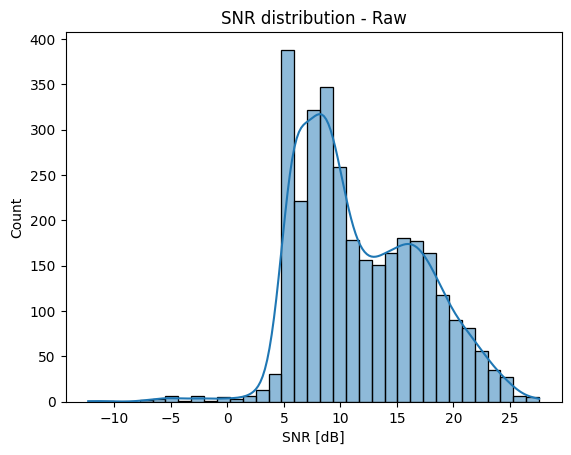

In [39]:
# Plot the SNR distribution
fig, ax = plt.subplots()
sns.histplot(df_files_snr["snr"], kde=True, ax=ax)
ax.set_title("SNR distribution - Raw")
ax.set_xlabel("SNR [dB]")
ax.set_ylabel("Count")
plt.show()

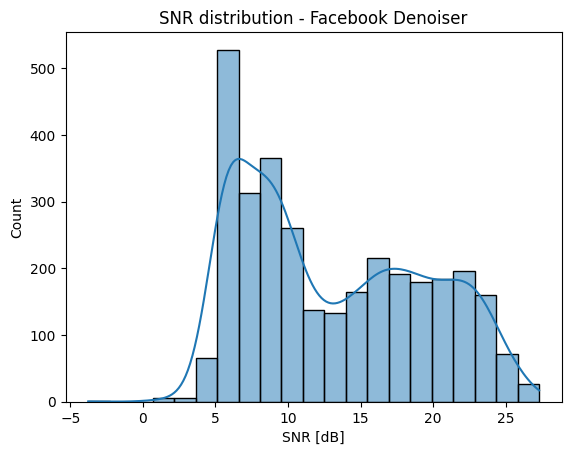

In [40]:
# Plot the SNR distribution
fig, ax = plt.subplots()
sns.histplot(df_files_snr_facebook_converted_snr["snr"], kde=True, ax=ax)
ax.set_title("SNR distribution - Facebook Denoiser")
ax.set_xlabel("SNR [dB]")
ax.set_ylabel("Count")
plt.show()

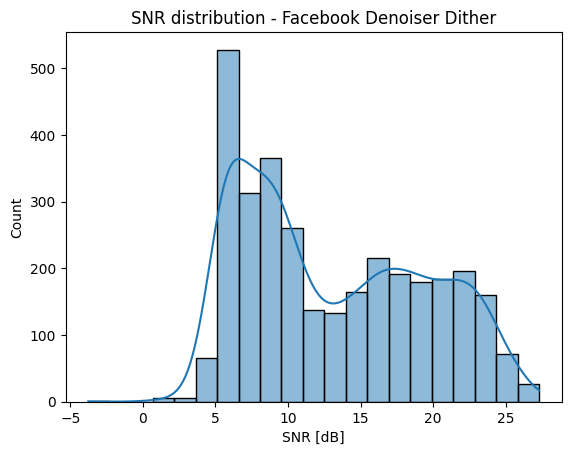

In [41]:
# Plot the SNR distribution
fig, ax = plt.subplots()
sns.histplot(df_files_snr_facebook_converted_dither_snr["snr"], kde=True, ax=ax)
ax.set_title("SNR distribution - Facebook Denoiser Dither")
ax.set_xlabel("SNR [dB]")
ax.set_ylabel("Count")
plt.show()

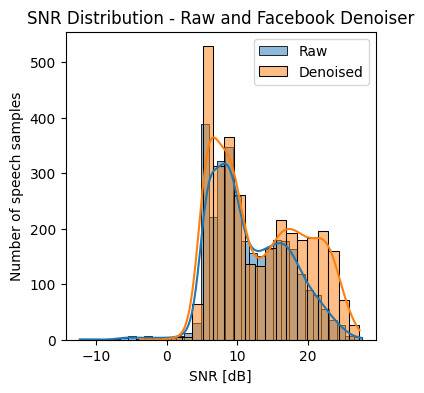

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create a new figure
plt.figure(figsize=(4, 4))

# Plot the SNR distribution for the raw data
sns.histplot(df_files_snr["snr"], kde=True, label="Raw")

# Plot the SNR distribution for the Facebook Denoiser data
sns.histplot(
    df_files_snr_facebook_converted_dither_snr["snr"], kde=True, label="Denoised"
)

plt.title("SNR Distribution - Raw and Facebook Denoiser")
plt.xlabel("SNR [dB]")
plt.ylabel("Number of speech samples")  # Y-axis label
plt.legend()

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join("figures", f"hist-snr_raw_and_denoising{cur_extension}"),
        bbox_inches="tight",
    )

plt.show()
plt.close()

In [43]:
# Try to embed fonts for the paper

import matplotlib as mpl

# Set the font to a serif one
mpl.rcParams["font.family"] = "serif"
# Ensure fonts are embedded in the output
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.size"] = 8

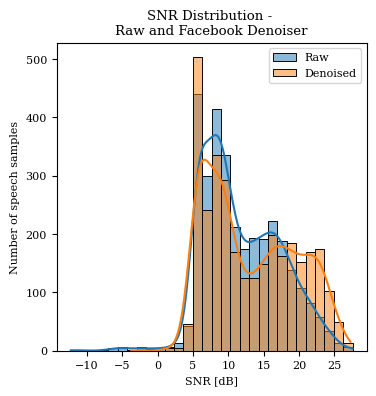

In [44]:
# Plot for paper: overlay and align both SNR distributions

# Define the number of bins
num_bins = 30

# Calculate the common range
common_range = (
    min(
        df_files_snr["snr"].min(),
        df_files_snr_facebook_converted_dither_snr["snr"].min(),
    ),
    max(
        df_files_snr["snr"].max(),
        df_files_snr_facebook_converted_dither_snr["snr"].max(),
    ),
)

# Create a new figure
plt.figure(figsize=(4, 4))

# Plot the SNR distribution for the raw data
sns.histplot(
    df_files_snr["snr"], kde=True, label="Raw", bins=num_bins, binrange=common_range
)

# Plot the SNR distribution for the Facebook Denoiser data
sns.histplot(
    df_files_snr_facebook_converted_dither_snr["snr"],
    kde=True,
    label="Denoised",
    bins=num_bins,
    binrange=common_range,
)

plt.title("SNR Distribution - \nRaw and Facebook Denoiser")
plt.xlabel("SNR [dB]")
plt.ylabel("Number of speech samples")  # Y-axis label
plt.legend()

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join("figures", f"hist-snr_raw_and_denoising{cur_extension}"),
        bbox_inches="tight",
    )

plt.show()
plt.close()

### More compact

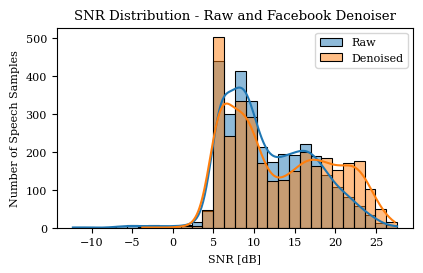

In [45]:
# Plot for paper: overlay and align both SNR distributions

# Define the number of bins
num_bins = 30

# Calculate the common range
common_range = (
    min(
        df_files_snr["snr"].min(),
        df_files_snr_facebook_converted_dither_snr["snr"].min(),
    ),
    max(
        df_files_snr["snr"].max(),
        df_files_snr_facebook_converted_dither_snr["snr"].max(),
    ),
)

# Create a new figure
plt.figure(figsize=(4.6, 2.6))

# Plot the SNR distribution for the raw data
sns.histplot(
    df_files_snr["snr"], kde=True, label="Raw", bins=num_bins, binrange=common_range
)

# Plot the SNR distribution for the Facebook Denoiser data
sns.histplot(
    df_files_snr_facebook_converted_dither_snr["snr"],
    kde=True,
    label="Denoised",
    bins=num_bins,
    binrange=common_range,
)

plt.title("SNR Distribution - Raw and Facebook Denoiser")
plt.xlabel("SNR [dB]")
plt.ylabel("Number of Speech Samples")  # Y-axis label
plt.legend()

# Save the figure
for cur_extension in [".png", ".pdf", ".svg"]:
    plt.savefig(
        os.path.join("figures", f"hist-snr_raw_and_denoising-compact{cur_extension}"),
        bbox_inches="tight",
    )

plt.show()
plt.close()

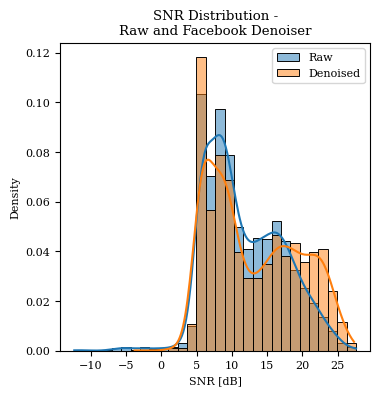

In [46]:
# Obsolete: density is not very graspable on y-axis

# Define the number of bins
num_bins = 30

# Calculate the common bin edges
bin_edges = np.linspace(
    min(
        df_files_snr["snr"].min(),
        df_files_snr_facebook_converted_dither_snr["snr"].min(),
    ),
    max(
        df_files_snr["snr"].max(),
        df_files_snr_facebook_converted_dither_snr["snr"].max(),
    ),
    num_bins + 1,
)

# Create a new figure
plt.figure(figsize=(4, 4))

# Plot the SNR distribution for the raw data
sns.histplot(df_files_snr["snr"], kde=True, label="Raw", bins=bin_edges, stat="density")

# Plot the SNR distribution for the Facebook Denoiser data
sns.histplot(
    df_files_snr_facebook_converted_dither_snr["snr"],
    kde=True,
    label="Denoised",
    bins=bin_edges,
    stat="density",
)

plt.title("SNR Distribution -\nRaw and Facebook Denoiser")
plt.xlabel("SNR [dB]")
plt.ylabel("Density")  # Y-axis label
plt.legend()

# Save the figure
# for cur_extension in [".png", ".pdf", ".svg"]:
#     plt.savefig(
#         os.path.join("figures", f"hist-snr_raw_and_denoising-density{cur_extension}"),
#         bbox_inches="tight",
#     )

plt.show()
plt.close()